# Fachprojekt Machine Learning
Authors: Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 1. May 2024

## Import necessary components

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


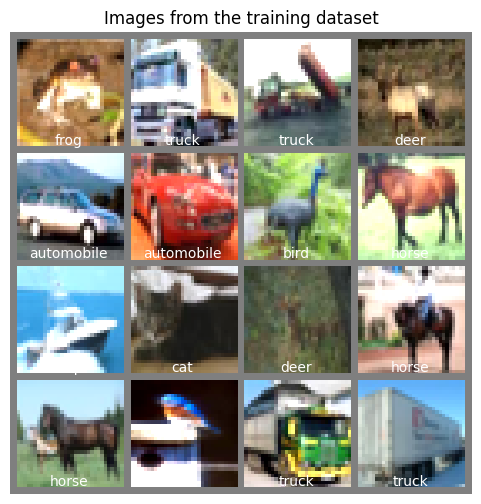

In [1]:
# Import the necessary libraries
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR

# Import the training and the testing datasets
from datasets import training_dataset, test_dataset

# Import the evaluation and the sampling function
from evaluation import evaluate
from sampling import sample

# Import the VAE model
import networks

## Set the hyperparameters, learning strategy, optimizer

In [ ]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 50 # One epoch means seeing every image of the training dataset, which consists of 50000 images
latent_dim = 100  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels
input_dim = 32 * 32 * input_channels  # Size of CIFAR-10 images (flattened)

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VAE(input_dim, latent_dim)
model.to(device)

# Optimizer selection
optimizer_option = 'adam'

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters())
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters())
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSProp(model.parameters())
else:
  optimizer = torch.optim.SGD(model.parameters())

# Learning rate scheduler parameters
lr_schedule_option = 'step'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

# Create data loaders for training and testing with the batch size from above.
# They can do things like multiprocessing and shuffling the order of the images.
# We can iterate over them to obtain batches of images and labels (see training loop below).
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training loop

In [ ]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
  BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + KLD

# We want to plot the accuracy at the end of training
loss_curve = []

# Training loop
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  losses = []

  for batch_idx, (data, _) in enumerate(training_loader):
    data = data.to(device)
    optimizer.zero_grad()
    
    with torch.cuda.amp.autocast():
      # Forward pass
      recon_batch, mu, logvar = model(data)
      
      # Compute loss
      loss = loss_function(recon_batch, data, mu, logvar)

    # Backward pass
    scaler.scale(loss).backward()
    
    # Optimization step
    scaler.step(optimizer)
    scaler.update()

    train_loss += loss.item()
    
  # Step the learning rate scheduler
  scheduler.step()

  # After the epoch, evaluate the accuracy on the test dataset
  mean_loss = evaluate(model, test_loader, loss_function)
  loss_curve.append(mean_loss)

  print(f'Epoch {epoch + 1}, Loss: {mean_loss}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

